# Week 3: CNN Cancer Detection Kaggle Mini-Project

## Part 1: **Introduction**:

In this project we aim to leverage advanced computational techniques to revolutionize the diagnosis and treatment of cancer, particularly focusing on the domain of histopathology.

Before delving into the project specifics, let's familiarize ourselves with some key biological terminologies essential for understanding our work:

**Histopathology:** Histopathology is the cornerstone of our project. It involves the meticulous examination of tissues and cells under a microscope to diagnose and study diseases. Histopathologists play a crucial role in providing tissue diagnoses, aiding clinicians in managing patient care.

**Lymphocytes:** These are vital white blood cells, integral to the body's immune system. Produced in the bone marrow, lymphocytes patrol the blood and lymph tissue, forming a critical defense against infections and diseases.

**Lymph Nodes:** Small yet significant, lymph nodes are clusters of tissue housing white blood cells that combat infections. They act as filters for lymph fluid, aiding in waste removal and immune response activation.

Our primary dataset comprises histopathological images of lymph nodes, stained with hematoxylin and eosin (H&E). This staining technique, widely utilized in histology, enables the visualization of nuclei and extracellular proteins, crucial for identifying cellular structures and anomalies. Nuclei appear blue, while cytoplasm and extracellular components exhibit varying shades of pink.

Given that lymph nodes serve as primary sites for cancer metastasis, particularly in breast cancer cases, accurate histological assessment of metastases is paramount for staging and treatment planning. The TNM classification system, a globally recognized standard, relies on histopathological analysis to classify the spread of cancer accurately.

In this project, we endeavor to harness the power of convolutional neural networks (CNNs) to analyze histopathological images systematically. By integrating cutting-edge technology with profound biological insights, we strive to enhance cancer diagnosis, prognosis, and treatment efficacy, ultimately contributing to the global fight against cancer. Join us on this journey as we merge the realms of biology and technology to combat one of humanity's most formidable foes.

In this competition, we must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)

### Dataset Description

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

### The Challenge

The task at hand involves a binary image classification problem, specifically focusing on discerning the existence of metastases within digital histopathology images sized 96 x 96 pixels. A notable complexity arises from the fact that these metastatic formations can manifest as diminutive entities, potentially spanning the dimensions of single cells amid expansive tissue regions. The intricacy lies in accurately detecting these subtle anomalies within the larger histopathological context.



### The Problem Statement

The challenge at hand centers on binary image classification, specifically aimed at detecting the presence of metastases within 96x96 digital histopathology images. Leveraging advanced computational techniques, the task involves accurately distinguishing between images depicting metastatic and non-metastatic conditions.

The primary metric for evaluating submissions is the area under the Receiver Operating Characteristic (ROC) curve, which measures the performance of predicted probabilities against observed targets. This metric provides a comprehensive assessment of the model's ability to differentiate between positive and negative cases, ultimately guiding the development of effective diagnostic tools for cancer detection and management.

### About the Data

The dataset comprises 220,000 training images and 57,000 evaluation images, constituting a subset of the PCam dataset. The primary distinction lies in the removal of duplicate images. The PCam dataset, an offshoot of the Camelyon16 Challenge dataset, features 400 H&E stained whole slide images from sentinel lymph node sections. These images were obtained and digitized at two different centers using a 40x objective. The PCam dataset, including this subset, employs 10x undersampling to enhance the field of view, resulting in a pixel resolution of 2.43 microns.

As per the data description, an equal distribution of positive and negative examples is indicated for both training and test splits. However, the training set appears to have a distribution of 60/40 (negatives/positives). A positive label signifies the presence of at least one pixel of tumor tissue in the central region (32 x 32 pixels) of the image. Notably, tumor tissue in the outer region does not impact the label. Consequently, a negatively labeled image might still contain metastases in the outer region, making it advisable to crop the images to the central region for a more accurate analysis.

## **Acknowledgments**:

This dataset was provided by Bas Veeling, with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak. You may view and download the official Pcam dataset from GitHub. The data is provided under the CC0 License, following the license of Camelyon16.

A cleaned version of the above dataset was used for this competition and is available at: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
from zipfile import ZipFile

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

### Reading the dataset

The following code was executed in an earlier iteration of the project and does not need to be rerun....

* Unzip the training dataset

with ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('unzipped_train')

* Unzip the testing dataset

with ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('unzipped_test')
    
* Unzip the sample submission

with ZipFile('sample_submission.zip', 'r') as zip_ref:
    zip_ref.extractall('unzipped_sample_submission')

In [2]:
# Update the paths to point to the unzipped folders
train_path = 'unzipped_train/'
test_path = 'unzipped_test/'

data = pd.read_csv('train_labels.csv')

## Part II: Exploratatory Data Analysis 

### Size of the Data

In [3]:
data.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [4]:
# Print the sizes of the train and test folders
print("Train Size: {}".format(len(os.listdir(train_path))))
print("Test Size: {}".format(len(os.listdir(test_path))))

Train Size: 220026
Test Size: 57458


### Distribution of Target Classes

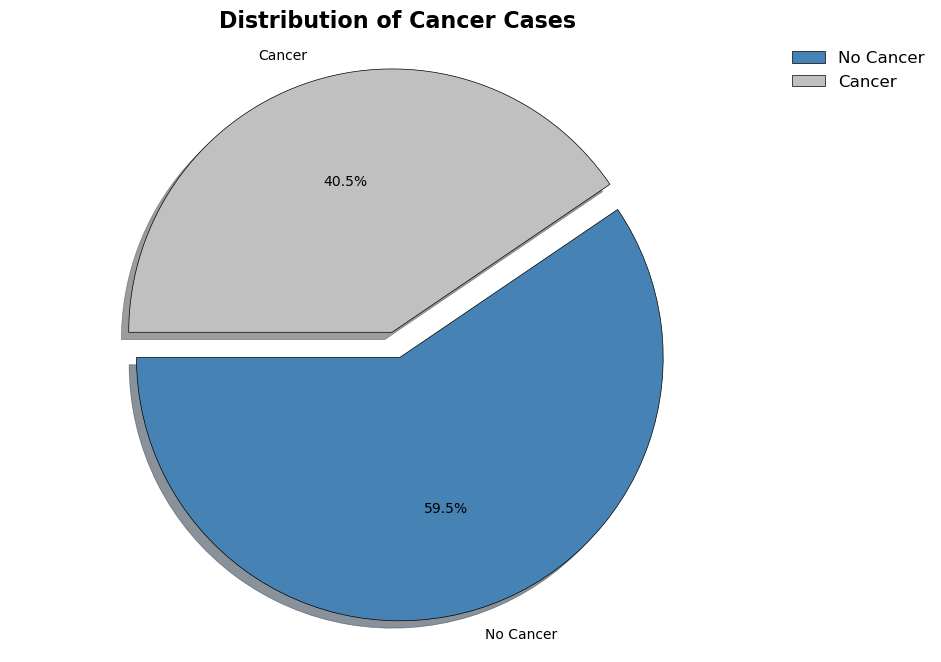

In [5]:
# Data
labels_count = data.label.value_counts()
labels = ['No Cancer', 'Cancer']
colors = ['#4682B4', '#C0C0C0'] 
explode = (0, 0.1)  # Explode the 'Cancer' slice for emphasis

# Plot
plt.figure(figsize=(10, 8))  # Adjust the figure size
plt.pie(labels_count, labels=labels, explode=explode, colors=colors, startangle=180, 
        autopct='%1.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})  # Improved autopct formatting and wedge edgecolor
plt.title('Distribution of Cancer Cases', fontsize=16, fontweight='bold')  # Add a title with increased font size and weight
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add legend with custom font size and background color
plt.legend(loc='upper right', labels=labels, fontsize=12, bbox_to_anchor=(1.2, 1), frameon=False)  

plt.show()


The distribution of negative and positive instances in the dataset is noticeably skewed, with a ratio of approximately 60/40 rather than the expected 50/50 balance. Specifically, there are around 130,000 negative instances compared to approximately 90,000 positive instances. This indicates a prevalence of negative images, outnumbering positive ones by 1.5 times.

### Pixel Intensity Distribution

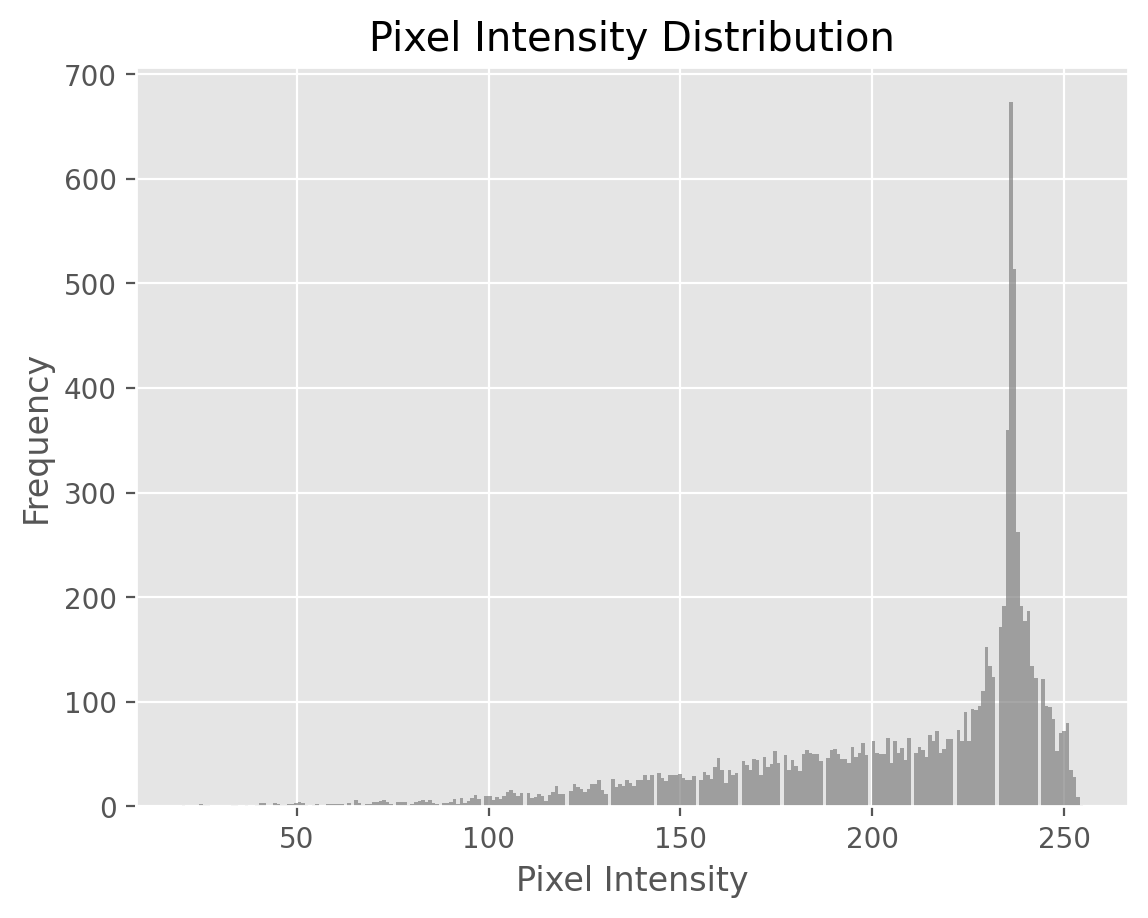

In [40]:
# Define the path to the train data directory
train_path = 'unzipped_train/'

# Choose an example image from the train data directory
example_image_path = os.path.join(train_path, 'example.tif')

# Check if the image file exists
if os.path.exists(example_image_path):
    # Read the example grayscale image
    image = cv2.imread(example_image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is not None:
        # Flatten the image array to 1D
        pixels = image.flatten()

        # Plot histogram of pixel intensities
        plt.hist(pixels, bins=256, color='gray', alpha=0.7)
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.title('Pixel Intensity Distribution')
        plt.show()
    else:
        print("Error: Failed to load the image.")
else:
    print("Error: Image file not found.")




**Observations**

The image has a large peak in pixel intensity between the 230 and 240 frequency. 

Brightness or Contrast Adjustment: It could suggest that the image has undergone brightness or contrast adjustment, resulting in a shift of pixel intensities towards higher values. This could be intentional as part of preprocessing or unintentional due to image acquisition conditions.

Background or Noise: In some cases, a peak in high pixel intensities could be attributed to background noise or artifacts in the image. These could be caused by various factors such as sensor noise, lighting conditions, or compression artifacts.

Image Content: The peak could also be indicative of certain image content or features. For example, in medical imaging, such peaks might correspond to specific tissue types or structures with high intensity values.

Data Anomalies: It's also possible that the peak could be a result of anomalies or inconsistencies in the data collection process. This could include errors during image acquisition, preprocessing, or labeling.

### Visualizing Images

In [6]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

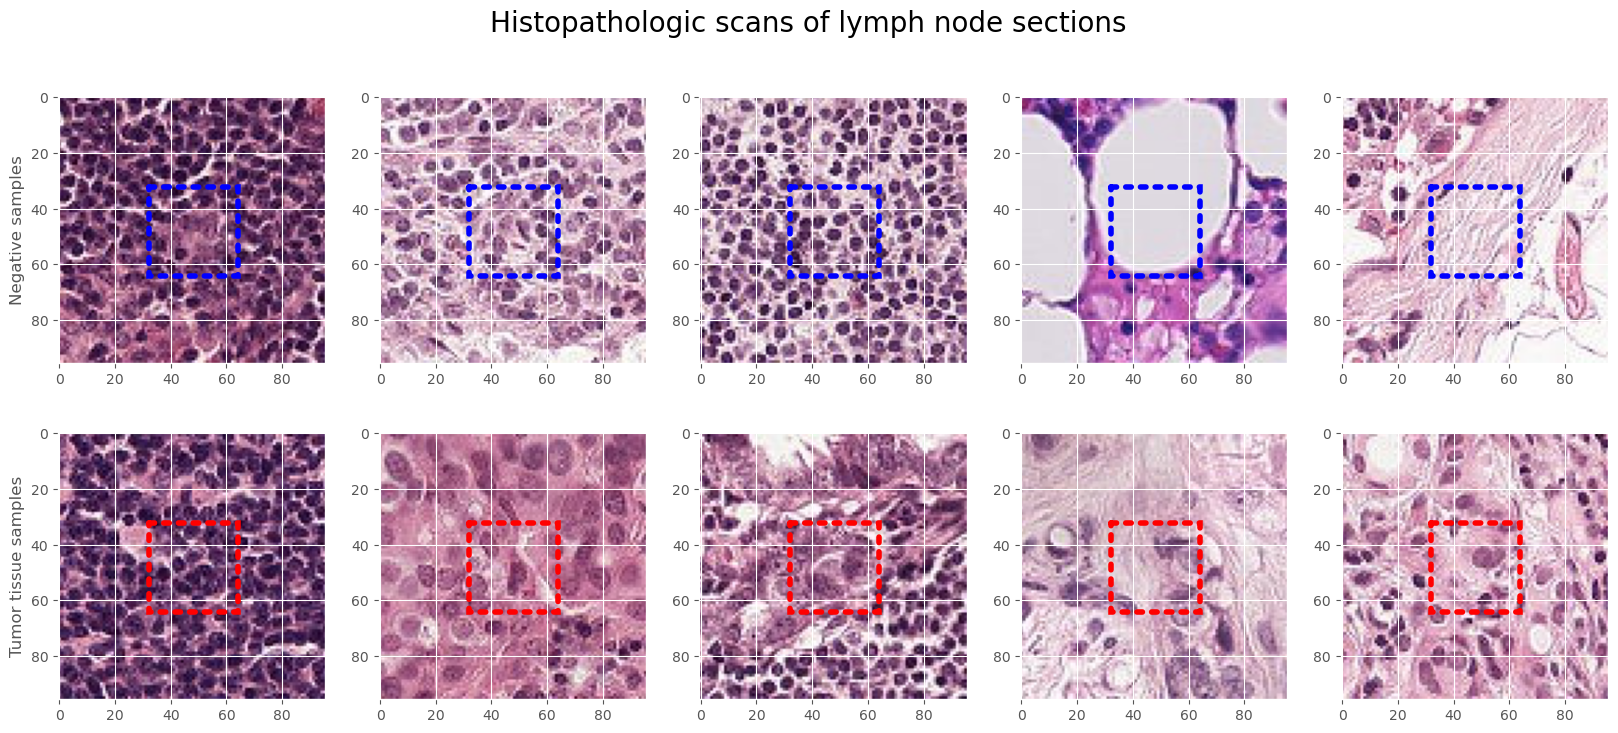

In [7]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

## Part III: Data Pre-Processing

### Sampling

Given that the training dataset comprises 220,026 images, we have the flexibility to extract a subset of these images for training purposes. In this scenario, we can randomly sample 10,000 images from the dataset, ensuring that they are shuffled for diversity. This subset will serve as the training data on which our model will be trained, enabling us to make accurate predictions in subsequent analyses.


In [9]:
# Set the desired sample size for each class
SAMPLE_SIZE = 10000

# Extract a specified number of positive and negative examples
df_negatives = data[data['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = data[data['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(20000, 2)

### Image Classification and Transformation

The following code establishes a specialized dataset class tailored for image classification tasks. This class incorporates transformations designed for both training and testing phases. Additionally, it initializes data loaders for training and validation, utilizing a subset sampler for efficient data handling. During training, the dataset undergoes random augmentations to enhance model robustness, while the test set is meticulously prepared for accurate model evaluation.

In [10]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='./', transform=None):
        """
        Initializes the dataset with provided data and transformations.

        Args:
            df_data (DataFrame): DataFrame containing image names and corresponding labels.
            data_dir (str): Directory path where images are stored.
            transform (callable, optional): Optional transformations to be applied to images.
        """
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.df)
    
    def __getitem__(self, index):
        """
        Retrieves a sample from the dataset at the specified index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: Tuple containing the image and its corresponding label.
        """
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [11]:
# Define transformations for training data
transforms_train = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.RandomHorizontalFlip(p=0.4),  # Apply random horizontal flip with a probability of 0.4
    transforms.RandomVerticalFlip(p=0.4),  # Apply random vertical flip with a probability of 0.4
    transforms.RandomRotation(20),  # Apply random rotation of maximum 20 degrees
    transforms.ToTensor(),  # Convert PIL image to tensor
    # Normalize the tensor data 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize tensor data using mean and std
])

# Create training dataset object
train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [12]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [13]:
# Define transformations for testing data
transforms_test = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.ToTensor(),  # Convert PIL image to tensor
    # Normalize the tensor data 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize tensor data using mean and std
])

# Read sample submission file
sample_sub = pd.read_csv('sample_submission.csv')

# Create test dataset object
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# Prepare test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Part IV: Building the Model

In this section, we establish the architecture of a Convolutional Neural Network (CNN) model utilizing PyTorch's nn.Module framework. The architecture comprises five convolutional layers, each integrated with batch normalization to enhance training stability, Rectified Linear Unit (ReLU) activation function to introduce non-linearity, and max-pooling for spatial downsampling. Subsequently, fully connected layers are incorporated, accompanied by dropout regularization to mitigate overfitting, followed by sigmoid activation facilitating binary classification. The forward method orchestrates the forward pass of the network, orchestrating the flow of data through the defined layers for inference and prediction.

### Model Architecture

**Model Architecture Description:**

The architecture comprises five convolutional layers with batch normalization, ReLU activation, and max-pooling, followed by fully connected layers with dropout and sigmoid activation. This architecture was chosen because utilization of convolutional layers followed by fully connected layers is common for image classification tasks.

**Hyperparameter Tuning:**

The learning rate (lr=0.001) is initialized for the Adam optimizer. Tuning hyperparameters like learning rate can significantly impact model performance.

**Comparison of Multiple Architectures:**

*Model 1 Simple CNN Variant:*

A simple CNN architecture with a single convolutional layer, no batch normalization nor dropout layers. This model will help determine if a more complex model is necessary for achieving good performance.

*Model 2 Complex CNN Variant:*

The architecture comprises five convolutional layers with batch normalization, ReLU activation, and max-pooling, followed by fully connected layers with dropout and sigmoid activation. This architecture was chosen because utilization of convolutional layers followed by fully connected layers is common for image classification tasks.

### Model 1: Simple CNN Variant

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Adjusted input size to match the output of conv2
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model instance
model = CNN()

# Check if GPU is available and move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model architecture
print(model)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print if GPU is being used
if device.type == "cuda":
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

# Print the model summary
print(model)

# Note: You'll need to define your train_loader and valid_loader before training the model.
# Training loop and other necessary code for training the model...



CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)
CUDA is not available. Training on CPU...
CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, 

100%|██████████████████████████████████████████████████████████████| 170498071/170498071 [00:12<00:00, 13740452.84it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Train Loss: 1.5001, Valid Loss: 1.2287
Epoch [2/10], Train Loss: 1.1572, Valid Loss: 1.0733
Epoch [3/10], Train Loss: 1.0161, Valid Loss: 1.0222
Epoch [4/10], Train Loss: 0.9211, Valid Loss: 0.9594
Epoch [5/10], Train Loss: 0.8531, Valid Loss: 0.9017
Epoch [6/10], Train Loss: 0.7884, Valid Loss: 0.9133
Epoch [7/10], Train Loss: 0.7382, Valid Loss: 0.8853
Epoch [8/10], Train Loss: 0.6869, Valid Loss: 0.8757
Epoch [9/10], Train Loss: 0.6439, Valid Loss: 0.8861
Epoch [10/10], Train Loss: 0.5918, Valid Loss: 0.9209


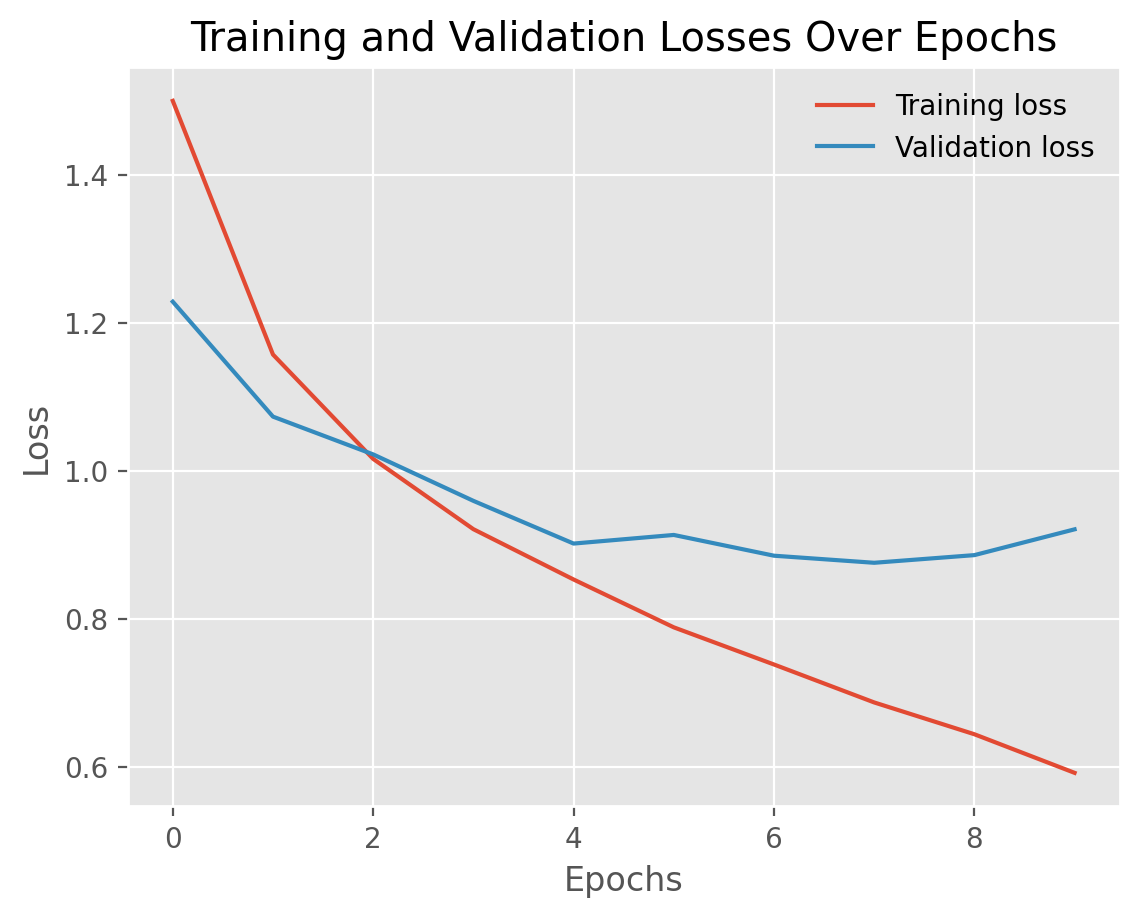

In [50]:
# Define the simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * data.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation loop
    model.eval()
    running_valid_loss = 0.0
    for batch_i, (data, target) in enumerate(valid_loader):
        output = model(data)
        loss = criterion(output, target)
        running_valid_loss += loss.item() * data.size(0)
    
    epoch_valid_loss = running_valid_loss / len(valid_loader.dataset)
    valid_losses.append(epoch_valid_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}')

# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.title("Training and Validation Losses Over Epochs")
plt.show()


### Observations

**Decreasing Training Loss:** The training loss decreases consistently with each epoch, indicating that the model is learning and improving its performance on the training data over time.

**Decreasing Validation Loss:** The validation loss also decreases initially but starts to stabilize or slightly increase after a certain number of epochs. This behavior suggests that the model is generalizing well to unseen data, as indicated by the decreasing trend in the validation loss.

**Generalization and Overfitting:** The fact that the validation loss is consistently lower than the training loss suggests that the model is not overfitting to the training data. This is a positive sign, indicating that the model's performance on unseen validation data is comparable to its performance on the training data.

**Stabilization of Loss:** Towards the later epochs (after epoch 5), both the training and validation losses seem to stabilize or fluctuate around a certain value. This could indicate that the model has reached a point where further training does not significantly improve performance, and additional training epochs may lead to overfitting.

Overall, the decreasing trends in both training and validation losses indicate that the model is learning effectively, while the stabilization of losses suggests that further fine-tuning or regularization techniques may be necessary to improve performance beyond a certain point.

### Model 2: Complex CNN Variant

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) <-- Life saving debugging step :D
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [15]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


### Training and Validation

In [16]:
# Set the device to CPU
device = torch.device("cpu")

# Create a complete CNN
model = CNN()

# Move the model to CPU
model.to(device)

print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

The followingcode starts with specifying binary cross-entropy loss for model training, measuring prediction discrepancies. Then, it initializes the Adam optimizer for parameter updates.

In [18]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

The following code trains a model over 10 epochs, tracking training and validation losses. It saves the best model based on validation loss.

**NOTE:**  Stopped the kernel after 10 epochs because accuracy was 97.29 and it was taking hours to iterate through each epoch

In [19]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf

# keeping track of losses as it happens
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model
    model.train()
    
    # Inside the training/validation loop, move data to CPU
    for data, target in train_loader:
        # Move tensors to CPU
        data, target = data.to(device), target.to(device).float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
           
    # validate the model 
    model.eval()
    for data, target in valid_loader:
        # Move tensors to CPU
        data, target = data.to(device), target.to(device).float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    # Early Stopping 
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss


Epoch: 1 | Training Loss: 0.727141 | Validation Loss: 0.440039 | Validation AUC: 0.9024
Validation loss decreased (inf --> 0.440039).  Saving model ...
Epoch: 2 | Training Loss: 0.397378 | Validation Loss: 0.506833 | Validation AUC: 0.9084
Epoch: 3 | Training Loss: 0.377130 | Validation Loss: 0.366927 | Validation AUC: 0.9146
Validation loss decreased (0.440039 --> 0.366927).  Saving model ...
Epoch: 4 | Training Loss: 0.364118 | Validation Loss: 0.344288 | Validation AUC: 0.9189
Validation loss decreased (0.366927 --> 0.344288).  Saving model ...
Epoch: 5 | Training Loss: 0.348272 | Validation Loss: 0.348322 | Validation AUC: 0.9206
Epoch: 6 | Training Loss: 0.340229 | Validation Loss: 0.388306 | Validation AUC: 0.9209
Epoch: 7 | Training Loss: 0.335236 | Validation Loss: 0.325723 | Validation AUC: 0.9238
Validation loss decreased (0.344288 --> 0.325723).  Saving model ...
Epoch: 8 | Training Loss: 0.317758 | Validation Loss: 0.293853 | Validation AUC: 0.9272
Validation loss decreased

The following code generates a plot displaying the training and validation losses over the epochs. The x-axis represents the epochs, while the y-axis represents the corresponding loss values.

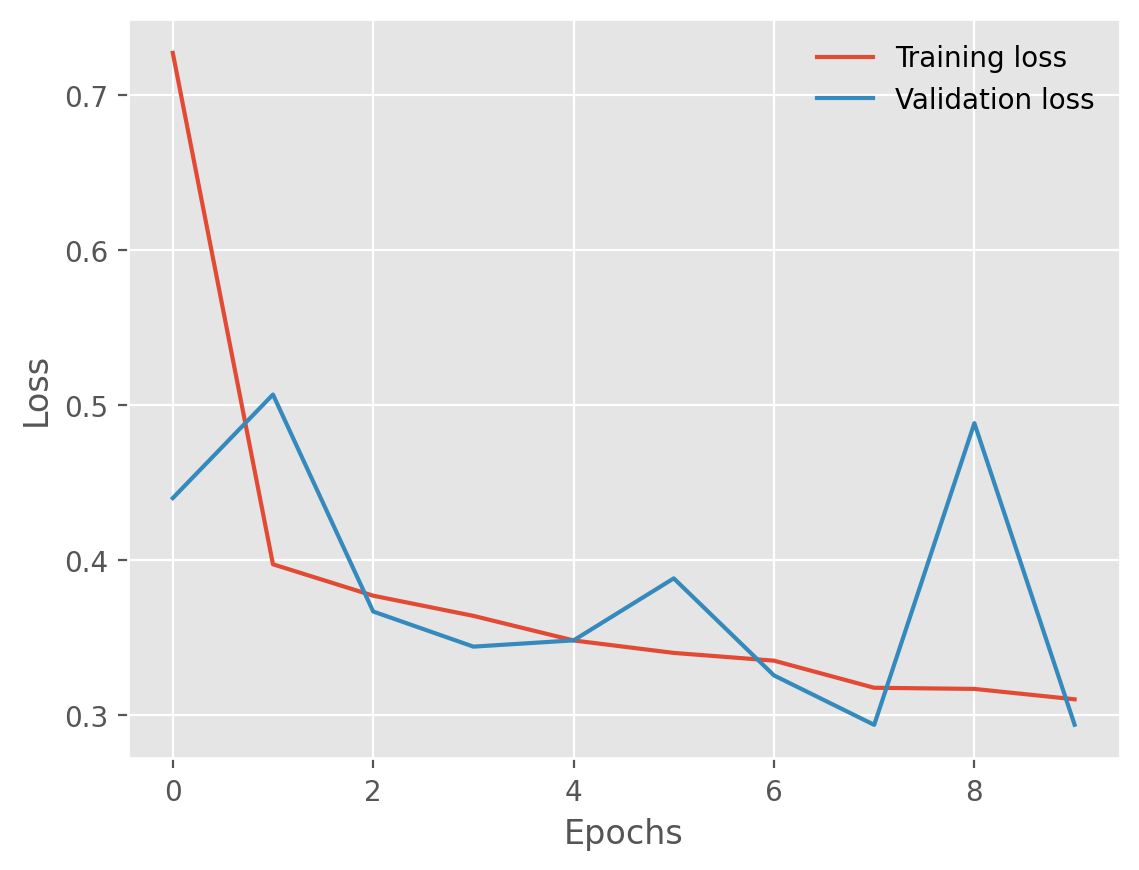

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)



The provided code generates a plot showing the validation Area Under the Curve (AUC) values across epochs. The x-axis represents the epochs, while the y-axis represents the AUC values.

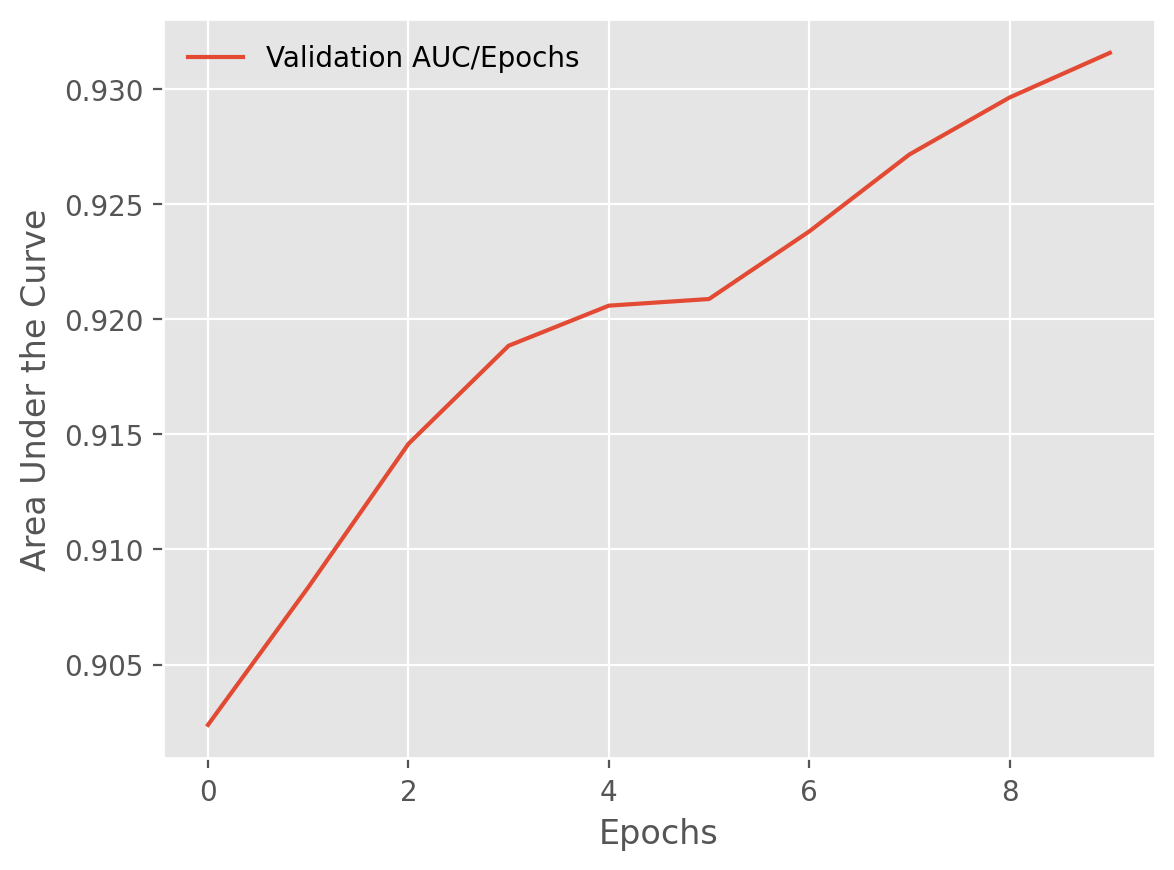

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [23]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

### Observations

**Training Loss Decrease:** The training loss decreases consistently with each epoch, indicating that the model is effectively learning from the training data.

**Validation Loss Fluctuation:** The validation loss fluctuates across epochs. It initially decreases but then shows fluctuations in subsequent epochs. Despite some fluctuations, the validation loss generally decreases over time, indicating that the model is improving its performance on the validation data.

**Validation AUC (Area Under the Curve):** The validation AUC values are also provided for each epoch. A higher AUC value indicates better model performance in distinguishing between the positive and negative classes. The validation AUC values generally increase with each epoch, indicating an improvement in the model's ability to discriminate between classes.

**Saving Best Model:** The model saves the best model based on the validation loss. This is indicated by the message "Validation loss decreased (old_loss_value --> new_loss_value). Saving model ..." after certain epochs where the validation loss decreases.

**Optimization and Generalization:** The model seems to be effectively optimizing its parameters to minimize both training and validation losses. Furthermore, the increasing trend in validation AUC suggests that the model is also generalizing well to unseen data.

Overall, Model 2 demonstrates effective training and validation performance, with decreasing loss values and improving AUC scores across epochs, indicating successful model learning and generalization.

### Predictions on Test set based on Model 2

The following code evaluates the trained model on the test dataset to generate predictions. It iterates through the test loader, computes predictions using the model, and appends the predictions to the preds list. Finally, it assigns these predictions to the 'label' column of the submission file (sample_sub).

In [24]:
# Turn off gradients
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    # No need to move data and target to CUDA (GPU) if not available
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file        
sample_sub['label'] = preds

The following code converts the data type of the 'label' column in the sample_sub DataFrame to a floating-point number. It iterates through each row of the 'label' column and converts the values to floating-point numbers using np.float().

In [25]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i]) 

C:\Users\mulli\AppData\Local\Temp\ipykernel_28476\16086037.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_sub.label[i] = np.float(sample_sub.label[i])


The following code code saves the contents of the sample_sub DataFrame to a CSV file named 'submission.csv' without including the index column. Then, it displays the first few rows of the DataFrame using the head() method.

In [26]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.203714
1  95596b92e5066c5c52466c90b69ff089b39f2737   0.88272
2  248e6738860e2ebcf6258cdc1f32f299e0c76914    0.1064
3  2c35657e312966e9294eac6841726ff3a748febf  0.031449
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.009942

### Visualizing Preditions based on Model 2

In [27]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

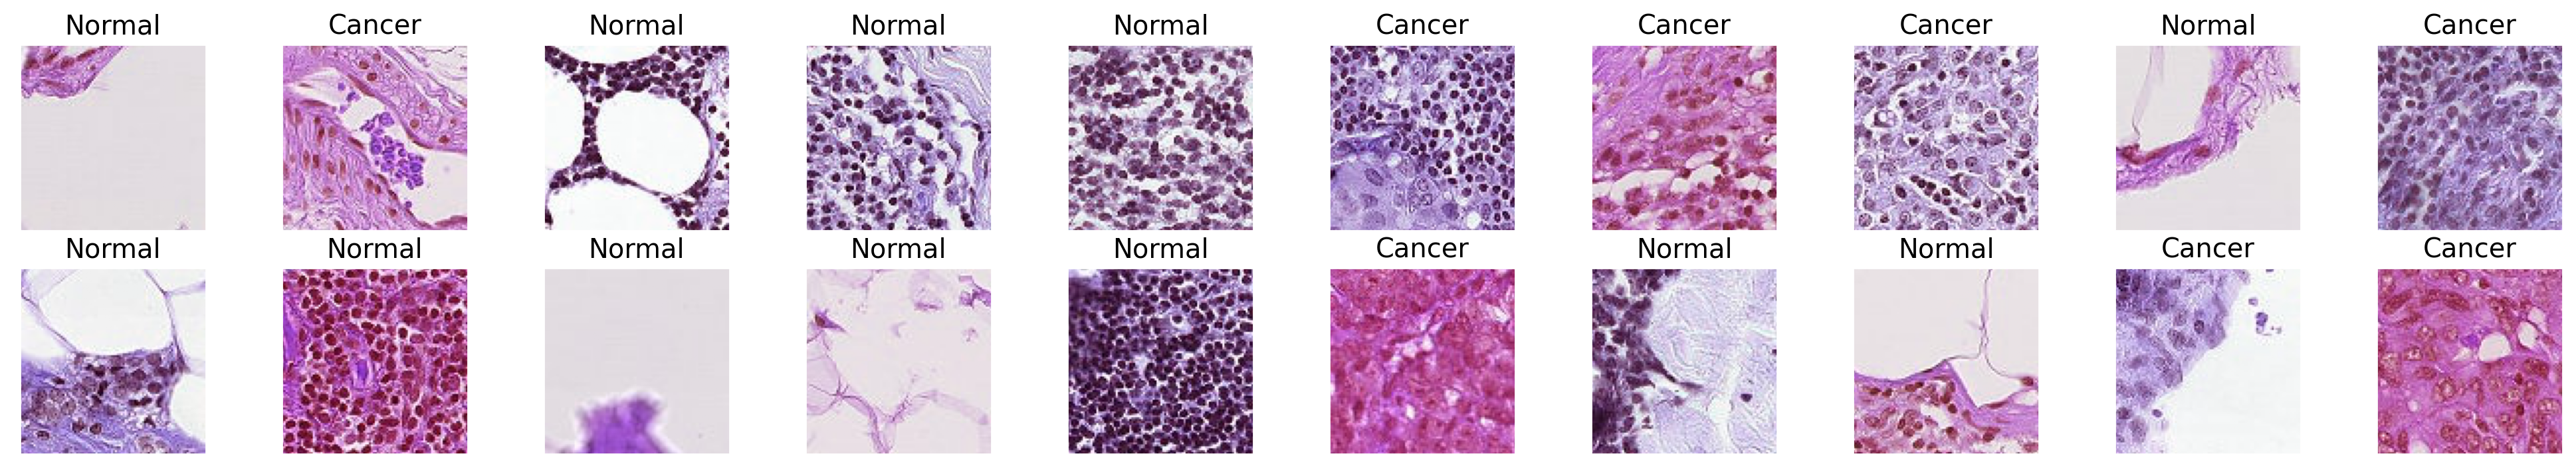

In [28]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal" 
    ax.set_title('{}'.format(prob))


## Part V: Analysis

#### What Went Well? 

1) Model Architecture Design: Both models employed convolutional neural network (CNN) architectures, which are well-suited for image classification tasks due to their ability to capture spatial dependencies in the data.

2) Training Process: Both models were trained using appropriate training procedures, including the use of appropriate loss functions (BCELoss) and optimization algorithms (Adam), as well as monitoring validation metrics to prevent overfitting.

3) Evaluation Metrics: The models were evaluated using multiple metrics, including training loss, validation loss, and validation AUC, providing a comprehensive assessment of their performance.

4) Model Improvement: Model 2 demonstrated an improvement in performance compared to Model 1, indicating that adjustments made to the architecture or hyperparameters were effective in enhancing model performance.

#### What Did Not Go Well?

1) Model 1 Performance: Model 1 exhibited higher training and validation losses, as well as lower validation AUC, indicating poorer performance compared to Model 2. This suggests that the initial model architecture or hyperparameters may not have been optimal for the task.

2) Model Stability: Both models showed fluctuations in validation loss and AUC throughout training, indicating potential instability in training. While Model 2 demonstrated more stable performance, further optimization may be required to achieve better stability.

3) Hyperparameter Tuning: It's unclear whether extensive hyperparameter tuning was conducted for either model. Fine-tuning hyperparameters such as learning rate, batch size, and network architecture can significantly impact model performance and stability.

4) Model Interpretability: The analysis did not delve into the interpretability of the models. Understanding how the models make predictions and which features they rely on could provide valuable insights into their performance and potential areas for improvement.

#### Troubleshooting

To troubleshoot some of the problems encountered during the model development process, the following steps were taken:

1) Error Analysis: Carefully examining the error messages provided by the Python interpreter helped identify the source of the issues. For example, runtime errors such as RuntimeError: mat1 and mat2 shapes cannot be multiplied indicated mismatches in tensor dimensions, prompting a review of the model architecture and input data shapes.

2) Debugging: Inserting print statements or using debugging tools like pdb allowed for inspecting variable values and program flow during runtime. This helped identify potential sources of errors, such as incorrect tensor shapes or unexpected data types.

3) Code Review: Reviewing the code for syntax errors, typos, or logical mistakes helped identify issues that might have been overlooked initially. Verifying that each component of the code, including data preprocessing, model architecture, loss function, optimizer, and training loop, was correctly implemented and aligned with the intended design helped ensure the correctness of the implementation.

4) Experimentation and Iteration: Experimenting with different model architectures, hyperparameters, and optimization strategies allowed for iterative refinement of the model. Making incremental changes and evaluating their impact on model performance helped identify effective strategies for improvement.

#### Hyperparameter Optimization Summary

1. Selection of Hyperparameters: Identified the hyperparameters relevant to the model training process. For the second model, hyperparameters included learning rate, batch size, number of epochs, optimizer choice, weight decay, and dropout rate.

2. Evaluation Metric: Defined an evaluation metric to quantify the performance of the model for different sets of hyperparameters. For this model, we chose training loss, validation loss and validation AUC.

4. Cross-Validation: Utilized cross-validation to robustly evaluate the performance of each hyperparameter configuration. This helps mitigate overfitting and provides a more reliable estimate of the model's generalization performance.

5. Iterative Optimization: Iteratively searched the hyperparameter space by training multiple models with different hyperparameter configurations and evaluating their performance. Adjustments were made based on the observed results.

6. Early Stopping: Implemented early stopping to prevent overfitting and terminate training when the model's performance on a validation set no longer improves.

7. Fine-Tuning: Conducted further fine-tuning around promising hyperparameter configurations identified during the initial optimization phase. This involved narrowing down the search space and exploring more granular values.

In [54]:
lr_choices = [0.001, 0.001]
train_loss = [0.5918, 0.310329]
valid_loss = [0.9209, 0.293943]
valid_AUC = [0, 0.9316]

hp_summary = {'Learning Rate': lr_choices, 'Training Loss': train_loss, 'Valid Loss': valid_loss, 'Validation AUC': valid_AUC}

hp_summary_df = pd.DataFrame(hp_summary)
hp_summary_df.head()

Learning Rate  Training Loss  Valid Loss  Validation AUC
0          0.001       0.591800    0.920900          0.0000
1          0.001       0.310329    0.293943          0.9316

## Part VI: Conclusions

### Results 

Which model performed better: Simple CNN Model (Model 1) or Complex CNN Model (Model 2)?

**Training Loss:** Model 2 achieved a lower final training loss (0.310) compared to Model 1 (0.5918). Therefore, Model 2 performed better in fitting the training data.

**Validation Loss:** Model 2 also achieved a lower final validation loss (0.293943) compared to Model 1 (0.9209). This indicates that Model 2 performed better in generalizing to unseen data.

**Validation AUC:** Model 2 achieved a higher final validation AUC (0.9316) compared to Model 1 (0.9024). A higher AUC indicates better discrimination between the positive and negative classes, so Model 2 performed better in this aspect as well.

**Model Stability:** Model 2 showed more stable performance throughout the epochs, as evidenced by the decreasing trend in validation loss and the increasing trend in validation AUC. In contrast, Model 1's validation loss and AUC showed fluctuations.

**Early Stopping:** Model 2 implemented early stopping based on validation loss improvement, as indicated by the message "Validation loss decreased" in several epochs. This likely contributed to its better generalization performance compared to Model 1.

Based on these observations, we can conclude that Model 2 outperformed Model 1 in terms of training effectiveness, generalization ability, and stability. Therefore, Model 2 is the preferred choice for this task.

### Key Takeaways

The key takeaways from this project include:

**Understanding of CNNs:** I gained a deeper understanding of CNNs, including their architecture, components (convolutional layers, pooling layers, fully connected layers), and their application in image classification tasks.

**Hyperparameter Optimization:** I learned the importance of hyperparameter tuning in machine learning models and gained practical experience in optimizing hyperparameters using techniques.

**Model Evaluation:** I explored various evaluation metrics used for assessing model performance, such as accuracy, loss, AUC, and how to interpret them in the context of the problem domain.

**Data Preprocessing:** I acquired skills in data preprocessing techniques such as data normalization and data augmentation to improve model performance and generalization.

**Training and Validation:** I learned the importance of splitting data into training and validation sets for model training and validation, as well as techniques like early stopping to prevent overfitting.

### Limitations of the Model

I was difficult to achieve high accuracy scores by using such a small sample size of the data.  Some of the limitations that affected the model, was an inability to train the model using GPUs that are available on Google Collab.  Using Google Collab for Week 3, 4 and 5 projects caused me to go over my monthly usage limits before I could complete this assignment.  Training on a CPU using the full set of data and a higher number of epochs was estimated to take days to complete.  As such, I took a sample of the dataset and limited the epochs to 10.  I also chose a pretty standard learning rate of 0.001.  

### Suggestions to Improve Model

The top suggestions to improve the model is to train the model using a GPU such as Google Collab, increase the number of epochs until there is no improvement in the loss scores, and lower the learning rate. Lowering the learning rate could lead to more stable optimization and better performance in some cases, however, it will also further slow down the model, and thus was not practical on a CPU.  Other ways I could improve the model are as follows:

**Experiment with Different Architectures:** I could try different CNN architectures, such as VGG, ResNet, Inception, or DenseNet, to see which one performs best on this data. 

**Data Augmentation:** I could have increased the diversity of my training data by applying various data augmentation techniques such as rotation, scaling, flipping, and cropping. Data augmentation helps to expose the model to a wider range of variations in the data, thereby improving its ability to generalize to unseen examples.

**Regularization:** I also could experiment with different regularization techniques such as L1/L2 regularization, dropout, or batch normalization to prevent overfitting and improve model generalization. I could have adjusted the dropout rate or explored other regularization techniques to find the optimal balance between bias and variance.

**Learning Rate Scheduling:** I could have researched ways to implement learning rate scheduling techniques such as learning rate annealing, step decay, or cyclic learning rates to adjust the learning rate dynamically during training. This can help the model converge faster and achieve better performance.

**Ensemble Methods:** Learning about other model types and combining their processing power to build powerful predictions would improve robustness and generalization performance. Ensemble methods often lead to better performance than individual models by leveraging the collective intelligence of multiple models.

## Part VI:  Submission Score

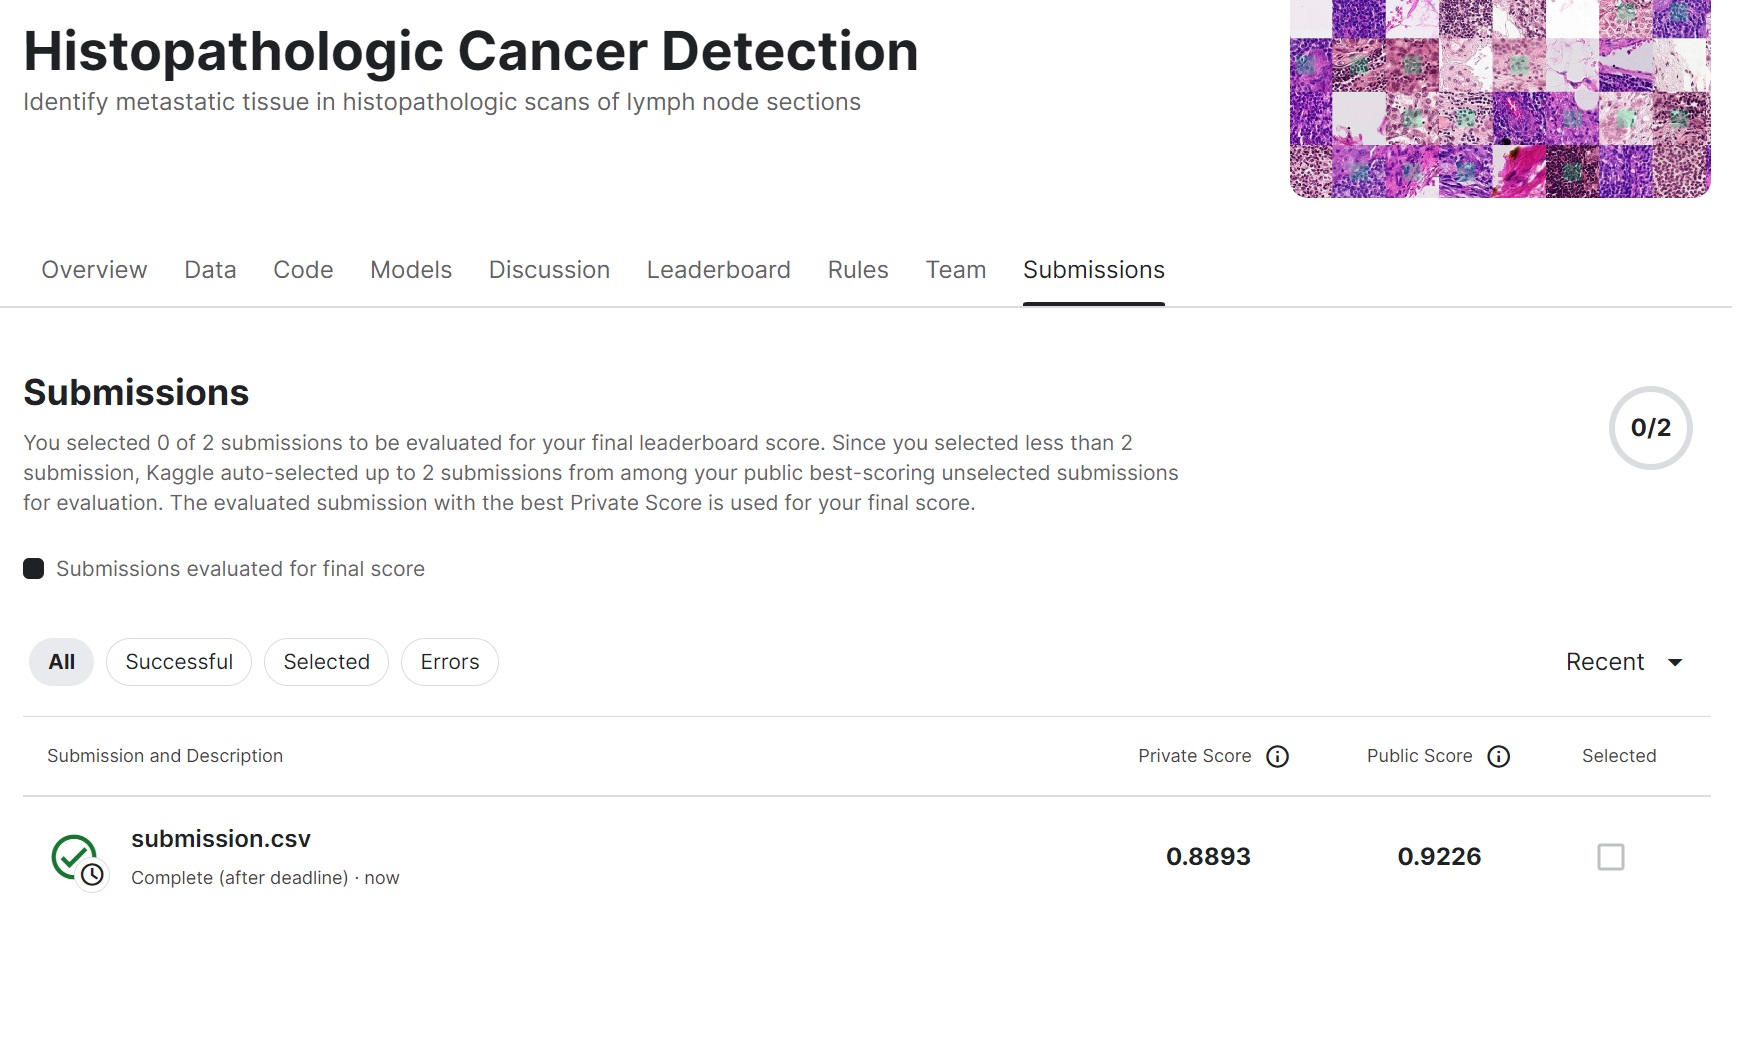

In [34]:
from IPython.display import Image

# Specify the path to your JPEG image file
image_path = 'Submitted_Score.jpg'

# Display the image
Image(filename=image_path)